We are implementing a Time Series forecast method to predict five years' future values based on historical time data for a fictional company in Australia.<br>
The company is a global manufacturing organisation with operations in three territories: America, Europe, and Asia.<br>
The company has two sales channels, online and reseller. It sells road bikes, mountain bikes, touring bikes, components, accessories, and clothing.

<h3> Import libraries

In [63]:
from datetime import datetime
import pyodbc # for commecting to sql
import pandas as pd
import numpy as np
import itertools
import seaborn as sns # gives better plots
sns.set(rc={'figure.figsize':(11, 4)})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'r'

#from termcolor import colored

In [107]:
# establish an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=Your server name;'
                      'Database=AdventureWorks2012;'
                      'Trusted_Connection=yes;')

sales = pd.read_sql_query("""
SELECT st.Name as Country
      , case soh.OnlineOrderFlag
      when 1 then 'Online'
      when 0 then 'Reseller'
      end as SalesChannels
      ,soh.OrderDate
      ,cast([OrderQty] * [UnitPrice] as decimal(10,2)) as [Total Sales]
  FROM [AdventureWorks2012].[Sales].[SalesOrderDetail] sod
  inner join [Sales].[SalesOrderHeader] soh
  on sod.SalesOrderID = soh.SalesOrderID
  inner join [Sales].[SalesTerritory] st
  on soh.TerritoryID = st.TerritoryID
  where soh.OnlineOrderFlag = 1
  and soh.OrderDate between '2011-05-31' and '2014-05-31'
  """, conn)

In [108]:
# display number of row and columns
sales.shape

(58268, 4)

To see what the data looks like, let’s use the head() and tail() methods to display the first three and last three rows.

In [109]:
sales.head(5)

,Country,SalesChannels,OrderDate,Total Sales
0,Canada,Online,2011-05-31,3578.27
1,France,Online,2011-05-31,3399.99
2,Northwest,Online,2011-05-31,3399.99
3,Southwest,Online,2011-05-31,699.10
4,Australia,Online,2011-05-31,3399.99


In [110]:
sales.tail()

,Country,SalesChannels,OrderDate,Total Sales
58263,Canada,Online,2014-05-31,7.95
58264,Canada,Online,2014-05-31,35.00
58265,Canada,Online,2014-05-31,35.00
58266,Canada,Online,2014-05-31,4.99
58267,Canada,Online,2014-05-31,34.99


<h3>Create Pandas DataFrame

In [111]:
df = pd.DataFrame(sales)
df.head()

,Country,SalesChannels,OrderDate,Total Sales
0,Canada,Online,2011-05-31,3578.27
1,France,Online,2011-05-31,3399.99
2,Northwest,Online,2011-05-31,3399.99
3,Southwest,Online,2011-05-31,699.10
4,Australia,Online,2011-05-31,3399.99


To access column Country and United Kingdom as the interesting label and the rows, we're going to use .loc and :

In [112]:
onlineChannel = sales.loc[sales.Country=='Australia',:]

In [113]:
# Let's use describe() method to return description of the data in the DataFrame
onlineChannel.describe()

,Total Sales
count,12988.000000
mean,696.950125
std,1083.221821
min,2.290000
25%,8.990000
50%,34.990000
75%,1120.490000
max,3578.270000


In [114]:
# let’s check out the data types of each column
onlineChannel.dtypes

Country                  object
SalesChannels            object
OrderDate        datetime64[ns]
Total Sales             float64
dtype: object

In [116]:
# Let's see the started date and end date of business
print('{}Started Date:{}'.format('\033[1m', '\033[0m'), sales['OrderDate'].min())
print('{}End Date:{}'.format('\033[1m', '\033[0m'), sales['OrderDate'].max())

Started Date: 2011-05-31 00:00:00
End Date: 2014-05-31 00:00:00


<h3>Data Preprocessing</h3>

In [117]:
# This will sum up 'Total Sales' and groupby 'OrderDate' and reset the index 
sales = onlineChannel.groupby('OrderDate')['Total Sales'].sum().reset_index()

<h4>Indexing with Time Series </h4>

Now that the OrderDate column is the correct data type (datetime64[ns]), let’s set it as the DataFrame’s index.

In [118]:
sales = sales.set_index('OrderDate')
sales.head()

,Total Sales
OrderDate,
2011-05-31,3399.99
2011-06-01,10353.25
2011-06-02,7156.54
2011-06-04,7855.64
2011-06-06,3578.27


In [119]:
sales.index

DatetimeIndex(['2011-05-31', '2011-06-01', '2011-06-02', '2011-06-04',
               '2011-06-06', '2011-06-07', '2011-06-08', '2011-06-09',
               '2011-06-10', '2011-06-11',
               ...
               '2014-05-22', '2014-05-23', '2014-05-24', '2014-05-25',
               '2014-05-26', '2014-05-27', '2014-05-28', '2014-05-29',
               '2014-05-30', '2014-05-31'],
              dtype='datetime64[ns]', name='OrderDate', length=1028, freq=None)

<h3>Resampling</h3>

By looking at our current datetime data it would be difficult to work with, instead, we will resample using the daily mean sales value for each month. And we are going to use the start of each month as the timestamp.

In [120]:
y = sales['Total Sales'].resample('MS').mean()
y = y.fillna(y.bfill()) #is used to backward fill the missing values in the dataset

In [121]:
y['2011':]

OrderDate
2011-05-01     3399.990000
2011-06-01     7638.997037
2011-07-01     7673.734483
2011-08-01     7391.396250
2011-09-01     8583.736000
2011-10-01     7504.718276
2011-11-01     9897.492593
2011-12-01     8581.120000
2012-01-01     7037.864444
2012-02-01     8440.044400
2012-03-01     8578.059630
2012-04-01     7327.146296
2012-05-01     7658.296786
2012-06-01     4526.312500
2012-07-01     5394.157037
2012-08-01     5058.931538
2012-09-01     6830.791538
2012-10-01     4266.104231
2012-11-01     6576.422000
2012-12-01     6134.310968
2013-01-01     7177.862581
2013-02-01     6581.040000
2013-03-01     7189.595667
2013-04-01     6838.872333
2013-05-01     6753.132000
2013-06-01     8474.067586
2013-07-01     6129.019677
2013-08-01    10949.811935
2013-09-01    11096.151333
2013-10-01    11462.072581
2013-11-01    12138.439333
2013-12-01    12649.957742
2014-01-01    14033.074839
2014-02-01    12684.657857
2014-03-01    15116.696129
2014-04-01    13770.552667
2014-05-01    1547

<h3>Visualising Sales Time Series Data

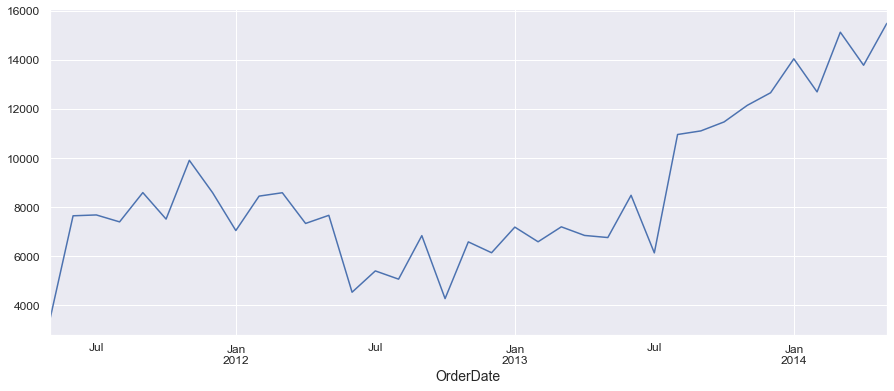

In [122]:
y.plot(figsize=(15,6))
plt.show()


Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

<h3>Additive Decomposition</h3>

An additive model suggests that the components are added together as follows y(t) = Trend + Seasonality + Noise

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

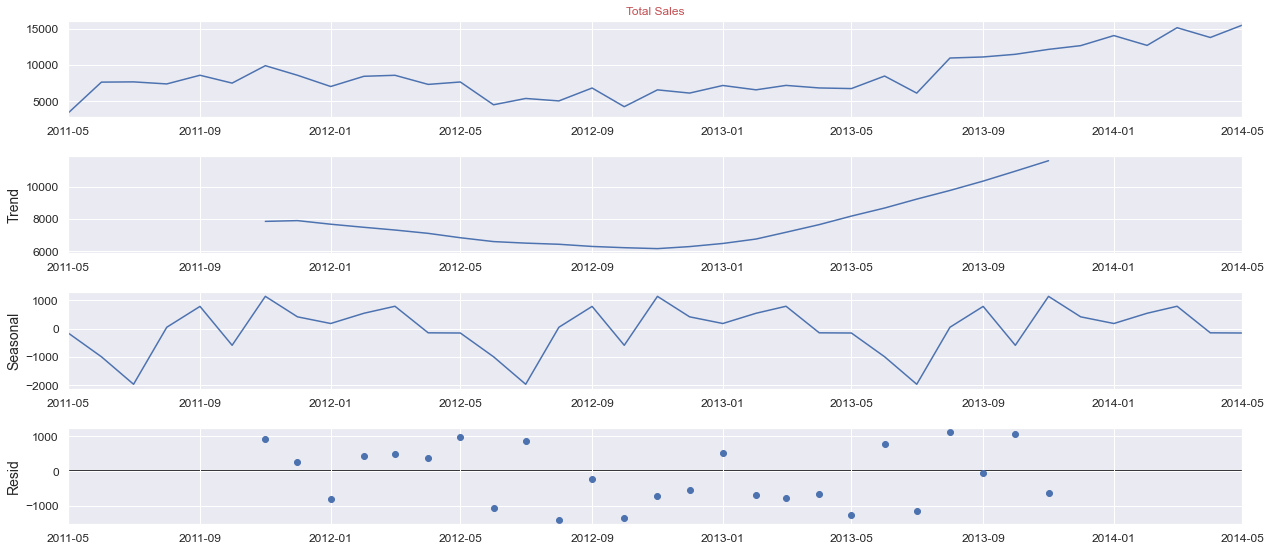

In [123]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model ='additive')
fig =decomposition.plot()
plt.rcParams.update({'font.size': 18})
plt.show()

<li>The first plot represents our sales time series data.</li> 
<li>The second plot represents the trend of our time series model extracted from the sales time series data.</li>
<li>Finally, the third and fourth plots represent seasonality and residual components in the same time series</li>

The first plot above clearly indicates that the sales is unstable, along with its obvious seasonality.

<h3>Time series forecasting with ARIMA</h3>

Autoregressive Integrated Moving Average (ARIMA), is one of the most commonly applied methods for time series forcasting
and is the method we are going to use for our sales time-series data.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [124]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Example of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Example of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter selection for our sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [125]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:761.3094769530577
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1083.9142283118013
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:475.64944313736873
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:247.3419543577365
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:494.4276973334114
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:436.1854724760595
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:258.631942581311
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:234.21542862470437
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.4057546390935
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2532.2027146196788
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:449.4367858315251
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:224.86741066280598
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:484.9070980959834
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:421.21198054133856
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:252.87520589917548
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:213.58429401081546
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:618.3040359809843
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:410.8804764387041
ARI

<b>This ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:202.7171233183783 </b>. 

Therefore, we should consider this to be the optimal option.

<h3>Fitting the ARIMA model

In [169]:
mod = sm.tsa.statespace.SARIMAX(y, 
                                order=(1,0,1), 
                                seasonal_order=(1,1,1,12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9517      0.076     12.575      0.000       0.803       1.100
ma.L1         -0.3273      0.228     -1.434      0.152      -0.775       0.120
ar.S.L12      -0.6309      0.447     -1.410      0.159      -1.508       0.246
ma.S.L12      -0.2216      0.880     -0.252      0.801      -1.945       1.502
sigma2      3.464e+06   5.21e-08   6.65e+13      0.000    3.46e+06    3.46e+06


The model summary reveals a lot of information. <br>The values under ‘coef’ are the weights of the respective terms.
<br>The p values in ‘P>|z|’ column, <b>ar.L1</b> has significant the rest of the terms have high insignificant. <br>
It should ideally be less than 0.05 for the respective X to be significant.<br>
We’ll accept this model, namely ARIMA(1, 0, 1)x(1, 1, 1, 12)12 model as it yeld the most optimal result.

<b>Let’s look at the residual diagnostics plot.

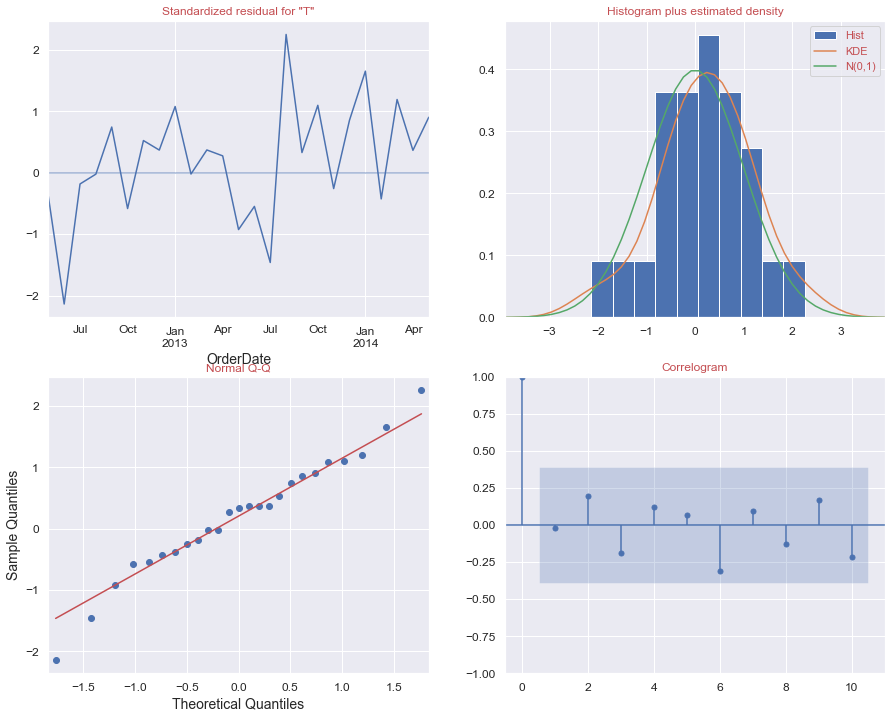

In [170]:
results.plot_diagnostics(figsize=(15,12))
plt.show()


<li>Top left: The standardised residual seem to fluctuate around a mean of zero.

<li>Top Right: The density plot suggest normal distributtion with mean zero.</li>

<li>Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

<li>Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

    
It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed

<h3>Validating forecasts</h3>

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2013–01–01 to the end of the data.

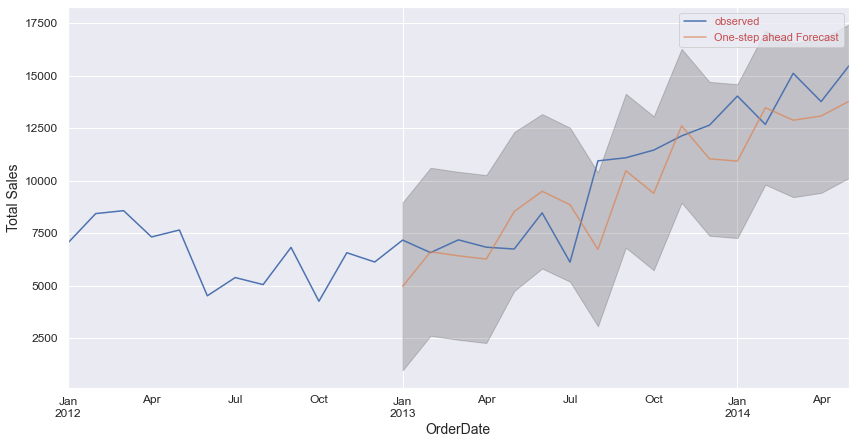

In [171]:
pred = results.get_prediction(start=pd.to_datetime('2013-01-01'),dynamic=False)
pred_ci = pred.conf_int()

ax=y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast',alpha=.7,figsize=(14,7))

ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='k',alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()

plt.show()

The line plot illustrates the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the actual values very well, showing an upward trend starting from the beginning and capturing the seasonality toward the end of the year.

<h3>Accuracy Metrics for Time Series Forecast

The two commonly used accuracy metrics to judge forecasts are:<br>
<li>MSE is used to check how close forecasts are to actual values. Lower the MSE, the closer is forecast to actual. <br>
 <li>RMSE to measure how erroneous the model's predictions are when compared to actual observed values. So a high RMSE is bad and a low RMSE is good

In [177]:
y_forecasted = pred.predicted_mean
y_truth = y['2013-01-01':]

mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse,2)))

The Mean Squared Error of our forecasts is 3598000.11


In [175]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse),2)))

The Root Mean Squared Error of our forecasts is 1896.84


<h3>Producing and visualising forecasts</h3>

5 years Sales Forecast

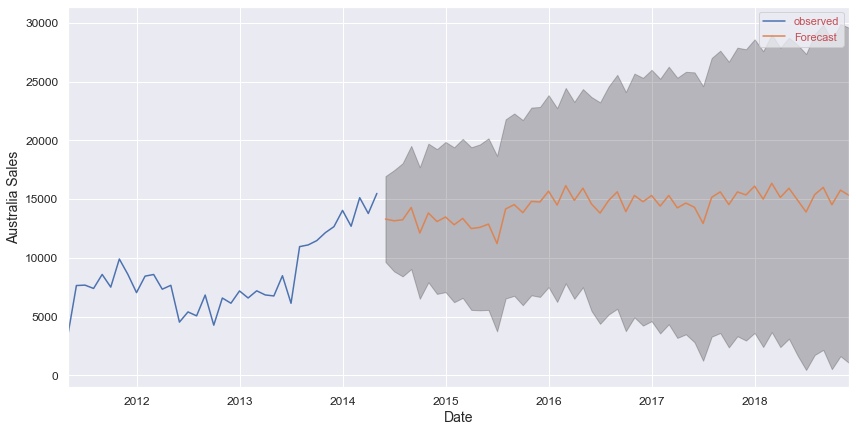

In [178]:
pred_uc = results.get_forecast(steps=55)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Australia Sales')
plt.legend()
plt.show()

We have successfully implemented five years forecast sales revenue is projected to show a steady overall sale for the company.
    

<h3> Conclusion</h3>

We have implemented a Time Series forecast method that predicted future values based on historical time data for our fictional company's online channel in Australia.<br>
The methods enables for analysing time series data in order to extract meaningful statistics and other characteristics of the data.<br>
We applied time series with ARIMA, one of the most commonly used method for time-series forecasting, which stands for Autoregressive Integrated Moving Average to forecast 5 years sales


<h3>Key Takeaways</h3>
<li>Regression with (Seasonal) ARIMA errors (SARIMAX) is a time series regression model that brings together two powerful   regression models namely, Linear Regression, and ARIMA (or Seasonal ARIMA).</li>
<li>The Python statsmodels.api library provides powerful support for building (S)ARIMAX models via the mod.sm.tsa.statespace.SARIMAX</li>
<li>While configuring the (S)ARIMA portion of the (S)ARIMAX model, it helps to use a set of well-known rules (combined with personal judgement) for fixing the values of the p,d,q parameters of the (S)ARIMAX model.</li>
<li>Additionally, you would want the residual errors to be homoscedastic, and (preferably) normally distributed. So you may have to experiment with different combinations of p,d,q until you get a model with the best goodness-of-fit characteristics.